Epoch 1/10, Loss: 2.2985
Epoch 2/10, Loss: 2.2489
Epoch 3/10, Loss: 2.1782
Epoch 4/10, Loss: 2.0996
Epoch 5/10, Loss: 2.0182
Epoch 6/10, Loss: 1.9362
Epoch 7/10, Loss: 1.8550
Epoch 8/10, Loss: 1.7752
Epoch 9/10, Loss: 1.6976
Epoch 10/10, Loss: 1.6229


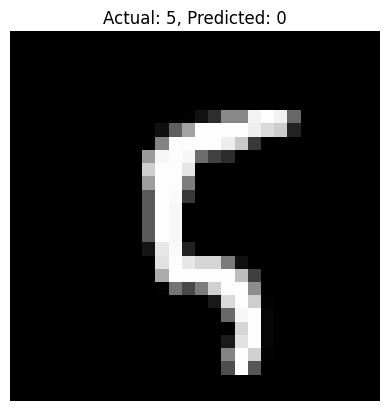

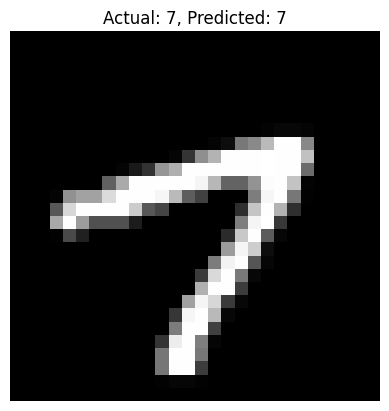

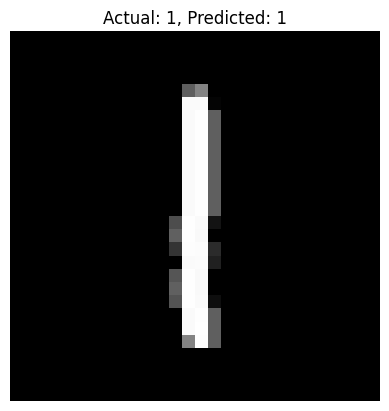

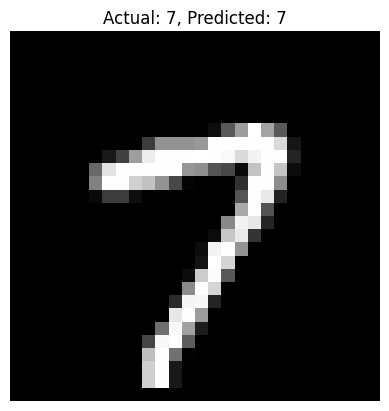

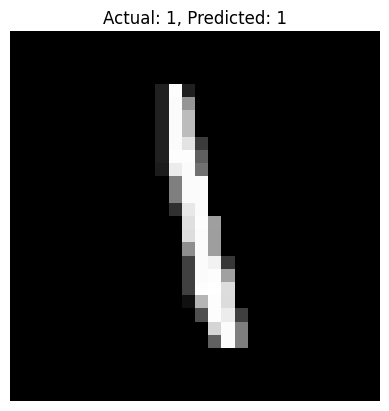

In [ ]:
import numpy as np
import struct
import matplotlib.pyplot as plt

def load_mnist_idx(filepath_images, filepath_labels):
    """Load the MNIST dataset from idx file format."""
    with open(filepath_images, 'rb') as img_file, open(filepath_labels, 'rb') as lbl_file:
        # Read image file header
        magic, num_images, rows, cols = struct.unpack(">IIII", img_file.read(16))
        assert magic == 2051, f"Invalid magic number in image file: {magic}"
        # Read label file header
        magic, num_labels = struct.unpack(">II", lbl_file.read(8))
        assert magic == 2049, f"Invalid magic number in label file: {magic}"
        assert num_images == num_labels, "Number of images and labels do not match."
        # Load images and labels
        images = np.frombuffer(img_file.read(), dtype=np.uint8).reshape(num_images, rows * cols) / 255.0
        labels = np.frombuffer(lbl_file.read(), dtype=np.uint8)
    return images, labels

def fuzzify_image(image):
    """Custom fuzzification: Apply a simple transformation to simulate fuzziness."""
    fuzzified = np.where(image > 0.5, 0.5, image)  # Example of limiting pixel intensity
    return fuzzified

def dense_layer(input_data, weights, biases):
    """Perform a dense layer operation."""
    return np.dot(input_data, weights) + biases

def relu(x):
    """Apply ReLU activation."""
    return np.maximum(0, x)

def softmax(x):
    """Apply softmax activation."""
    exp_x = np.exp(x - np.max(x))  # Stability improvement
    return exp_x / np.sum(exp_x)

def cross_entropy_loss(predicted, actual):
    """Calculate cross-entropy loss."""
    return -np.log(predicted[actual])

def gradient_descent(weights, biases, input_data, predicted, actual, learning_rate=0.01):
    """Perform gradient descent to update weights and biases."""
    one_hot_actual = np.zeros_like(predicted)
    one_hot_actual[actual] = 1
    gradient = predicted - one_hot_actual
    weights_gradient = np.outer(input_data, gradient)
    biases_gradient = gradient
    weights -= learning_rate * weights_gradient
    biases -= learning_rate * biases_gradient
    return weights, biases

def ann_forward(input_data, weights_hidden, biases_hidden, weights_output, biases_output):
    """Perform a forward pass through an ANN."""
    # Hidden Layer
    hidden_output = relu(dense_layer(input_data, weights_hidden, biases_hidden))
    # Output Layer
    output_layer = dense_layer(hidden_output, weights_output, biases_output)
    return hidden_output, output_layer

def train_ann(train_pixels, train_labels, weights_hidden, biases_hidden, weights_output, biases_output, epochs=10, learning_rate=0.01):
    """Train the ANN using gradient descent."""
    for epoch in range(epochs):
        total_loss = 0
        for i, (input_data, actual) in enumerate(zip(train_pixels, train_labels)):
            # Forward pass
            hidden_output, logits = ann_forward(input_data, weights_hidden, biases_hidden, weights_output, biases_output)
            predicted = softmax(logits)
            # Compute loss
            loss = cross_entropy_loss(predicted, actual)
            total_loss += loss
            # Backward pass
            weights_output, biases_output = gradient_descent(weights_output, biases_output, hidden_output, predicted, actual, learning_rate)
            weights_hidden, biases_hidden = gradient_descent(weights_hidden, biases_hidden, input_data, hidden_output, actual, learning_rate)
        avg_loss = total_loss / len(train_pixels)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

def plot_metrics(train_losses):
    """Plot training metrics."""
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

def visualize_prediction(pixels, labels, weights_hidden, biases_hidden, weights_output, biases_output, num_samples=5):
    """Visualize predictions on sample images."""
    for i in range(num_samples):
        input_data = pixels[i]
        actual = labels[i]
        _, logits = ann_forward(input_data, weights_hidden, biases_hidden, weights_output, biases_output)
        predicted = np.argmax(softmax(logits))
        plt.imshow(input_data.reshape(28, 28), cmap='gray')
        plt.title(f"Actual: {actual}, Predicted: {predicted}")
        plt.axis('off')
        plt.show()

# Paths to the MNIST dataset files
train_images_path = '/Users/Sudharsan/Downloads/MNIST dataset/train-images.idx3-ubyte'
train_labels_path = '/Users/Sudharsan/Downloads/MNIST dataset/train-labels.idx1-ubyte'

# Load the dataset
pixels, labels = load_mnist_idx(train_images_path, train_labels_path)

# Use a small subset of data for testing
train_pixels, val_pixels = pixels[:100], pixels[100:200]
train_labels, val_labels = labels[:100], labels[100:200]

# Initialize ANN components
input_size = 28 * 28
hidden_size = 128
output_size = 10
weights_hidden = np.random.rand(input_size, hidden_size) * 0.01
biases_hidden = np.zeros(hidden_size)
weights_output = np.random.rand(hidden_size, output_size) * 0.01
biases_output = np.zeros(output_size)

# Train the ANN
train_ann(train_pixels, train_labels, weights_hidden, biases_hidden, weights_output, biases_output, epochs=10, learning_rate=0.01)

# Visualize sample predictions
visualize_prediction(val_pixels, val_labels, weights_hidden, biases_hidden, weights_output, biases_output, num_samples=5)